In [5]:
import pandas as pd
import numpy as np
import spacy
from collections import Counter
import os
from IPython.display import display, HTML
import json


## Compute a reference corpus

In [53]:
#comparison corpus german
from tei_reader import TeiReader
reader = TeiReader()
import os

dir_de_ref = 'swiss_history_books/reference_corpus_german/dta_kernkorpus_1700-1799_2020-07-20/'
dir_de_lemmatized = 'swiss_history_books/reference_corpus_german/dta_kernkorpus_1700-1799_2020-07-20_lemmatized/'

text_corpus_de = []
for files in os.listdir(dir_de_ref)[:100]:

    corpora = reader.read_file(dir_de_ref+files)
    
    ref_text = corpora.text.replace('ſ', 's')#replace ſ with s
    ref_text_cleaned = ' '.join([el for el in ref_text.split() if len(el) > 1])
    
    ref_text_lematized = lematization_pos_tagging(nlp_de, ref_text_cleaned[:1000000])#rate limit at 1 million limit texts
    text_corpus_de.append(ref_text_lematized)
    
    with open(dir_de_lemmatized+files[:-4]+".txt", "w") as text_file:
        text_file.write(' '.join(ref_text_lematized))
    


In [54]:
#comparison corpus french
from tei_reader import TeiReader
reader = TeiReader()


dir_fr_ref = 'swiss_history_books/reference_corpus_french/17_xml/'
dir_fr_lemmatized = 'swiss_history_books/reference_corpus_french/17_galica_lemmatized/'


text_corpus_de = []
for files in os.listdir(dir_fr_ref)[:100]:
    
    corpora = reader.read_file(dir_fr_ref+files)
    ref_text = corpora.text

    ref_text_cleaned = ' '.join([el for el in ref_text.split() if len(el) > 1])
    
    ref_text_lematized = lematization_pos_tagging(nlp_fr, ref_text_cleaned[:1000000])#rate limit at 1 million limit texts
    text_corpus_de.append(ref_text_lematized)
    
    with open(dir_fr_lemmatized+files[:-4]+".txt", "w") as text_file:
        text_file.write(' '.join(ref_text_lematized))
        
        

## Read in swiss history books 

In [32]:
#read in
path= '/home/nulpe/Desktop/H-D_Project/swiss_history_books/german_swiss_nation_building_texts/'
ch_dir = [path+ 'Der_Geschichten_schweizerischer_Eidgenos.txt', path+'Die Schweiz im neunzehnten Jahrhundert.txt']# ,[path+'Aegidii_Tschudii_gewesenen_Land_Ammanns.txt'] 
fr_dir = [path+'Histoire_de_la_Confédération_Suisse-1.txt', path+'la_suisse_19_siecle.txt']

lst_schweizer_geschichte = []
for el in ch_dir:
    with open(el) as f:
        schweizer_geschichte = f.read()
    lst_schweizer_geschichte.append(schweizer_geschichte)


lst_confederation_suisse = []
for el in fr_dir:
    with open(el) as f:
        confederation_suisse = f.read()
    lst_confederation_suisse.append(confederation_suisse)



In [33]:
# preprocessing
pos_to_keep = ['ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB']

def lematization_pos_tagging(tagging_language_funtion, text):
    doc = tagging_language_funtion(text)
    lemmatized = [x.lemma_ for x in doc if x.pos_ in pos_to_keep and x.is_stop != True and len(x.lemma_)>1]
    print()
    return lemmatized

#load spacy corpuses
nlp_de = spacy.load('de_core_news_md')
nlp_fr = spacy.load('fr_core_news_sm')

In [34]:
#lemmatize german and french version

for idx, schweizer_geschichte in enumerate(lst_schweizer_geschichte):
    schweizer_geschichte = schweizer_geschichte.replace('ſ', 's')#replace ſ with s
    schweizer_geschichte_lematized = lematization_pos_tagging(nlp_de, schweizer_geschichte[:1000000])
    #schweizer_tf = Counter(schweizer_geschichte_lematized)
    lst_schweizer_geschichte[idx]=schweizer_geschichte_lematized
    
for idx, confederation_suisse in enumerate(lst_confederation_suisse):    
    confederation_suisse_lemmatized = lematization_pos_tagging(nlp_fr, confederation_suisse[:1000000])
    #confederation_tf = Counter(confederation_suisse_lemmatized)
    lst_confederation_suisse[idx]=confederation_suisse_lemmatized



In [35]:
#pre processing with lematization

#print(schweizer_tf)
#print((confederation_tf))
lst_schweizer_geschichte_final = ''
for el in lst_schweizer_geschichte: lst_schweizer_geschichte_final+=' '.join(el) 
#lst_schweizer_geschichte_final = [' '.join(el) for el in lst_schweizer_geschichte_final]
schweizer_tf = Counter(lst_schweizer_geschichte_final)
lst_confederation_suisse_final = [' '.join(el) for el in lst_confederation_suisse]
confederation_tf = Counter(lst_confederation_suisse_final)

schweizer_tf_top_100 = [(el, schweizer_tf[el])   for  el in schweizer_tf]
schweizer_tf_top_100 = sorted(schweizer_tf_top_100, key=lambda tup: tup[1], reverse=True)
confederation_tf_top_100 = [(el, confederation_tf[el])  for el in confederation_tf]
confederation_tf_top_100 = sorted(confederation_tf_top_100, key=lambda tup: tup[1], reverse=True)


#print(schweizer_tf_top_100[:100])
#print(confederation_tf_top_100[:100])

print(len(lst_schweizer_geschichte_final))


# --> join again the list of strings 

1053968


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk 
dir_de_lemmatized = 'swiss_history_books/reference_corpus_german/dta_kernkorpus_1700-1799_2020-07-20_lemmatized/'
dir_fr_lemmatized = 'swiss_history_books/reference_corpus_french/17_galica_lemmatized/'

def ref_corp(dir_lemmatized):
    text_corpus = []
    for path in os.listdir(dir_lemmatized):
        with open(dir_lemmatized+path) as f:
             text_corpus.append(f.read())
    return text_corpus

def k_gram_corpus(text_corpus, k_gram):
    bigram_corpus = []
    for doc in text_corpus:
        gram_doc = ' '.join([el[0]+'_'+el[1]  for el in nltk.ngrams(doc.split(), 2) if len(el[0]) > 3 and len(el[1]) > 3 ])
        if k_gram == 3: gram_doc+= ' '.join([el[0]+'_'+el[1]+'_'+el[2]   for el in nltk.ngrams(doc.split(), k_gram) if len(el[0]) > 3 and len(el[1]) > 3 ])
        bigram_corpus.append(gram_doc)
    return bigram_corpus


#corpus in fr and de
text_corpus_de = ref_corp(dir_de_lemmatized)
text_corpus_fr = ref_corp(dir_fr_lemmatized)
lst_schweizer_geschichte_final = [' '.join(el) for el in lst_schweizer_geschichte]

lst_schweizer_geschichte_final = ''
for el in lst_schweizer_geschichte: lst_schweizer_geschichte_final+=' '.join(el) 

lst_confederation_suisse_final = [' '.join(el) for el in lst_confederation_suisse]
text_corpus_de.append(lst_schweizer_geschichte_final)
text_corpus_fr.append(' '.join(lst_confederation_suisse_final))



#Unigrams 
vectorizer_de = TfidfVectorizer()
vectorizer_fr = TfidfVectorizer()
de = vectorizer_de.fit_transform(text_corpus_de)
fr = vectorizer_fr.fit_transform(text_corpus_fr)


#Bigrams
text_corpus_de_bigram = k_gram_corpus(text_corpus_de, 3) 
text_corpus_fr_bigram = k_gram_corpus(text_corpus_fr, 3)



vectorizer_de_bi = TfidfVectorizer(token_pattern=r'\S+')
vectorizer_fr_bi = TfidfVectorizer(token_pattern=r'\S+')
de_bi = vectorizer_de_bi.fit_transform(text_corpus_de_bigram)
fr_bi = vectorizer_fr_bi.fit_transform(text_corpus_fr_bigram)


#ToDo:
#fix bigrams....
#add german french history texts 

In [37]:

for el in text_corpus_fr_bigram[50].split():
    if '_'  not in el:
        print(el)
        
print('\n')

#bigram_corpus.append(' '.join([doc.split()[idx]+'_'+doc.split()[idx+1]  for idx in range(len(doc.split())-1)]))

print(len(text_corpus_de), len(text_corpus_de_bigram))
print(len(text_corpus_fr_bigram), len(text_corpus_fr_bigram))



101 101
101 101


In [38]:
def make_tfidf_table(matrix, vectorizer_lang):
    tfidf = pd.DataFrame(matrix[-1].toarray().T)
    tfidf.index = vectorizer_lang.get_feature_names()
    return tfidf.sort_values(by = 0, ascending=False).reset_index()



schweizer_geschichte_tfidf = make_tfidf_table(de, vectorizer_de)
confederation_suisse_tfidf = make_tfidf_table(fr, vectorizer_fr)

schweizer_geschichte_tfidf_bi = make_tfidf_table(de_bi, vectorizer_de_bi)
confederation_suisse_tfidf_bi = make_tfidf_table(fr_bi, vectorizer_fr_bi)

print(pd.concat([confederation_suisse_tfidf[:40],  confederation_suisse_tfidf_bi[:40]], axis=1)) 
print(pd.concat([schweizer_geschichte_tfidf[:40],schweizer_geschichte_tfidf_bi[:40]], axis=1))


          index         0                   index         0
0      rodolphe  0.332392            comte_pierre  0.094150
1         comte  0.245470          comte_rodolphe  0.081074
2       tschudi  0.221161            comte_savoie  0.071239
3         berne  0.198825             ville_berne  0.054141
4         ville  0.158460         abbé_saint-gall  0.054141
5        zurich  0.147188        maison_habsbourg  0.051292
6        albert  0.119029             marc_argent  0.048723
7            ch  0.117110      rodolphe_habsbourg  0.048442
8        suisse  0.116733           comte_palatin  0.047075
9     bourgeois  0.115486          comte_eberhard  0.042743
10     seigneur  0.114379         bourgeois_berne  0.042743
11          roi  0.107952          jean_bubenberg  0.039894
12    habsbourg  0.107745          avoyer_conseil  0.039894
13         jean  0.107196          rodolphe_broun  0.039894
14         pays  0.106166          empereur_louis  0.039229
15      château  0.105915          emper

## N-Grams Impresson & Latex conform print out

In [39]:
print(' '.join(schweizer_geschichte_tfidf['index'][:50].tolist()))

kanton schweiz regierung truppe französisch zürich tagsatzung partei frankreich eidgenössisch helvetischen behörde luzern droz eidgenossenschaft verfassung bern waadt helvetische bürger schweizerisch öffentlich verninac erklären französische consul wallis juli märz schwyz republik bundesrat freiburg helvetien volk genf neutralität mehrheit abgeordnete basel militärisch minister rat reding politisch dezember land aargau juni bonaparte


In [41]:
print(' '.join(confederation_suisse_tfidf['index'][:50].tolist()))

rodolphe comte tschudi berne ville zurich albert ch suisse bourgeois seigneur roi habsbourg jean pays château charte évêque waldstetten kibourg guerre hartmann bernois maison schwyz abbé empereur saint savoie henri chevalier grand neuchâtel duc fribourg gall eberhard bâle chron pierre alliance couvent baron temps fils homme frère zuricoi erlach impérial


In [51]:
lst_bigrams = []
for el in schweizer_geschichte_tfidf_bi['index'][:25].tolist(): lst_bigrams+= el.split('_') 
print(' '.join(lst_bigrams))

numa droz französisch truppe helvetische regierung helvetischen republik droz wiedergeburt öffentlich meinung droz protektorat bull lois helvetische republik helvetischen regierung französisch regierung ordnung ding regie rung kanton bern französische regierung vollz nathes kanton waadt prot vollz zürich bern demokratisch kanton protof vollz numa droz wiedergeburt verfassung geben lluma droz numa droz protektorat


In [52]:
lst_bigrams = []
for el in confederation_suisse_tfidf_bi['index'][:25].tolist(): lst_bigrams+= el.split('_') 
print(' '.join(lst_bigrams))

comte pierre comte rodolphe comte savoie marc argent abbé saint-gall ville berne maison habsbourg comte palatin rodolphe habsbourg empereur henri comte eberhard bourgeois berne jean bubenberg rodolphe broun avoyer conseil empereur louis comte habsbourg comte amédée bourgeois ville comte kibourg comte hartmann pierre gruyère suisse allemand cent marc empereur frédéric


In [10]:
print(pd.concat([pd.Series(['&']*50), confederation_suisse_tfidf['index'][:50],pd.Series(['&']*50), confederation_suisse_tfidf[0][:50],pd.Series(['&']*50), 
                 confederation_suisse_tfidf_bi[:50]['index'].apply(lambda x: x.replace('_', ' ')),pd.Series(['&']*50), confederation_suisse_tfidf_bi[0][:50], pd.Series(['\\\\']*50)], axis=1))




    0        index  1         0  2                   index  3         0   4
0   &     rodolphe  &  0.332393  &            comte pierre  &  0.094145  \\
1   &        comte  &  0.245470  &          comte rodolphe  &  0.081070  \\
2   &      tschudi  &  0.221161  &            comte savoie  &  0.071235  \\
3   &        berne  &  0.198825  &         abbé saint-gall  &  0.054139  \\
4   &        ville  &  0.158460  &             ville berne  &  0.054139  \\
5   &       zurich  &  0.147189  &        maison habsbourg  &  0.051289  \\
6   &       albert  &  0.119029  &             marc argent  &  0.048720  \\
7   &           ch  &  0.117110  &      rodolphe habsbourg  &  0.048440  \\
8   &       suisse  &  0.116733  &           comte palatin  &  0.047073  \\
9   &    bourgeois  &  0.115486  &         bourgeois berne  &  0.042741  \\
10  &     seigneur  &  0.114379  &          comte eberhard  &  0.042741  \\
11  &          roi  &  0.107953  &          rodolphe broun  &  0.039892  \\
12  &    hab

In [59]:

def pretty_print(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))

pretty_print(pd.concat([pd.Series(['&']*50), schweizer_geschichte_tfidf['index'][:50],pd.Series(['&']*50), schweizer_geschichte_tfidf[0][:50],pd.Series(['&']*50), 
                 schweizer_geschichte_tfidf_bi[:50]['index'].apply(lambda x: x.replace('_', ' ')),pd.Series(['&']*50), schweizer_geschichte_tfidf_bi[0][:50], pd.Series(['\\\\']*50)], axis=1))



,0,index,1,0,2,index,3,0,4
0,&,kanton,&,0.517982,&,numa droz,&,0.113806,\\
1,&,schweiz,&,0.314341,&,französisch truppe,&,0.096147,\\
2,&,regierung,&,0.165484,&,helvetische regierung,&,0.090260,\\
3,&,truppe,&,0.153276,&,helvetischen republik,&,0.074563,\\
4,&,französisch,&,0.146008,&,droz wiedergeburt,&,0.068676,\\
5,&,zürich,&,0.143091,&,öffentlich meinung,&,0.066714,\\
6,&,tagsatzung,&,0.127124,&,droz protektorat,&,0.064752,\\
7,&,partei,&,0.126443,&,bull lois,&,0.062790,\\
8,&,frankreich,&,0.107725,&,helvetische republik,&,0.056903,\\
9,&,eidgenössisch,&,0.106244,&,helvetischen regierung,&,0.056903,\\


## Time trends Impresso

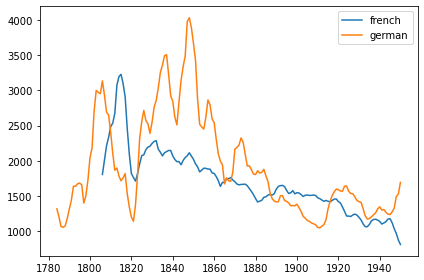

In [144]:
import datetime
def time_trend_agg(json):
    n=0
    data = []
    for el in json.data[0][:5]:
        for val in el['items']:
            #print(val)
            data.append([val['date'], val['total'], val['ppm']])

    df = pd.DataFrame(data, columns = ['date', 'total', 'ppm'])
    return df

    


gdl_trend = '/home/nulpe/Desktop/H-D_Project/swiss_history_books/ngrams_trends/unigrams_confederation.json'
nzz_trend = '/home/nulpe/Desktop/H-D_Project/swiss_history_books/ngrams_trends/unigrams_eidgenossenschaft.json'

trends_french = pd.read_json(gdl_trend, lines=True)
df_confederation = time_trend_agg(trends_french)
df_confederation_agg = df_confederation.groupby('date').agg(['sum'])

df_confederation_agg['date'] = pd.to_datetime(df_confederation_agg.index)
df_confederation_agg = df_confederation_agg[df_confederation_agg['date']<datetime.datetime(1950, 6, 1)]

df_confederation_agg['ppm_rolling_mean'] = df_confederation_agg['ppm'].rolling(window=5).mean()


trends_nzz = pd.read_json(nzz_trend, lines=True)
df_ceidgenoss = time_trend_agg(trends_nzz)
df_ceidgenoss_agg = df_ceidgenoss.groupby('date').agg(['sum'])
df_ceidgenoss_agg['date'] = pd.to_datetime(df_ceidgenoss_agg.index)
df_ceidgenoss_agg = df_ceidgenoss_agg[df_ceidgenoss_agg['date']<datetime.datetime(1950, 6, 1)]

df_ceidgenoss_agg['ppm_rolling_mean'] = df_ceidgenoss_agg['ppm'].rolling(window=5).mean()

    
plt.plot(pd.to_datetime(df_confederation_agg.index), df_confederation_agg.ppm_rolling_mean, label='french')
plt.plot(pd.to_datetime(df_ceidgenoss_agg.index), df_ceidgenoss_agg.ppm_rolling_mean, label='german')

ax.set_ylabel("Occurencies (per milion tokens)")
ax.set_xlabel("Decade")
ax.set_title("Frequency of mentions in Swiss newspapers of \nextracted words from sociology papers")
plt.legend()
plt.tight_layout()
plt.savefig("both.png", dpi=600)



In [145]:
rows = []
with open("normalization/nzz-counts.impresso", "r") as f:
    for line in f.readlines():
        rows.append(json.loads(line))
        
nzz_df = pd.DataFrame(rows[0][1][0])
nzz_df = nzz_df.buckets.apply(lambda row: pd.Series({'year': row['val'], 'article_count': row['count']}))
nzz_df = nzz_df.sort_values(by='year')

rows = []
with open("normalization/gdl-counts.impresso", "r") as f:
    for line in f.readlines():
        rows.append(json.loads(line))
        
        
gdl_df = pd.DataFrame(rows[0][1][0])
gdl_df = gdl_df.buckets.apply(lambda row: pd.Series({'year': row['val'], 'article_count': row['count']}))
gdl_df = gdl_df.sort_values(by='year')

In [146]:
df_ceidgenoss_agg.columns = ["_".join(x) for x in df_ceidgenoss_agg.columns.ravel()]
df_confederation_agg.columns = ["_".join(x) for x in df_confederation_agg.columns.ravel()]

<ipython-input-146-ba493d580173>:1: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  df_ceidgenoss_agg.columns = ["_".join(x) for x in df_ceidgenoss_agg.columns.ravel()]
<ipython-input-146-ba493d580173>:2: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  df_confederation_agg.columns = ["_".join(x) for x in df_confederation_agg.columns.ravel()]


In [155]:

df_ceidgenoss_agg_articles = df_ceidgenoss_agg.merge(nzz_df,left_index=True, right_on='year', how= 'left')
df_ceidgenoss_agg_articles['count_article_normalized'] = df_ceidgenoss_agg_articles['total_sum'] /df_ceidgenoss_agg_articles['article_count']
df_ceidgenoss_agg_articles['count_article_normalized_rolling_mean'] = df_ceidgenoss_agg_articles['count_article_normalized'].rolling(window=5).mean()

df_confederation_agg_articles = df_confederation_agg.merge(gdl_df,left_index=True, right_on='year', how= 'left')
df_confederation_agg_articles['count_article_normalized'] = df_confederation_agg_articles['total_sum'] /df_confederation_agg_articles['article_count']
df_confederation_agg_articles['count_article_normalized_rolling_mean'] = df_confederation_agg_articles['count_article_normalized'].rolling(window=5).mean()


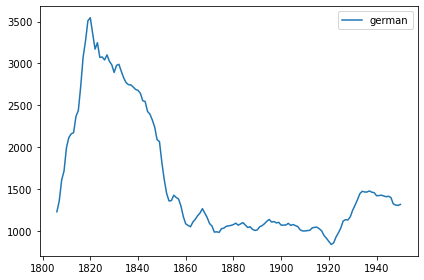

In [158]:


plt.plot(pd.to_datetime(df_ceidgenoss_agg_articles.year), df_ceidgenoss_agg_articles.count_article_normalized_rolling_mean, label='french')
plt.plot(pd.to_datetime(df_confederation_agg_articles.year), df_confederation_agg_articles.count_article_normalized_rolling_mean, label='german')

ax.set_ylabel("Occurencies (per milion tokens)")
ax.set_xlabel("Decade")
ax.set_title("Frequency of mentions in Swiss newspapers of \nextracted words from sociology papers")
plt.legend()
plt.tight_layout()
plt.savefig("both.png", dpi=600)



In [ ]:
plt.plot(pd.to_datetime(df_confederation_agg.index), df_confederation_agg.ppm_rolling_mean, label='french')
plt.plot(pd.to_datetime(df_ceidgenoss_agg.index), df_ceidgenoss_agg.ppm_rolling_mean, label='german')

ax.set_ylabel("Occurencies (per milion tokens)")
ax.set_xlabel("Decade")
ax.set_title("Frequency of mentions in Swiss newspapers of \nextracted words from sociology papers")
plt.legend()
plt.tight_layout()
plt.savefig("both.png", dpi=600)


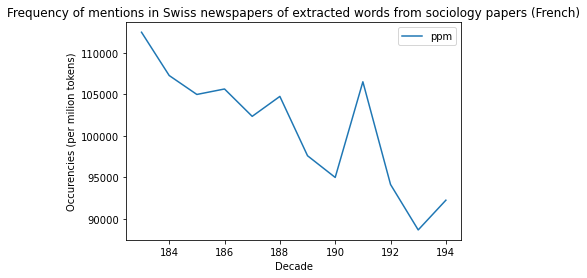

In [17]:
ax = trends_french.plot(x='date', y='ppm')
ax.set_ylabel("Occurencies (per milion tokens)")
ax.set_xlabel("Decade")
ax.set_title("Frequency of mentions in Swiss newspapers of extracted words from sociology papers (French)")
plt.savefig("french.png", dpi=600)